In [1]:
%matplotlib inline

import math
from enum import IntEnum

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz

from sklearn import tree, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, Imputer

In [2]:
def convert_raw_csv(input_file, output_file):
    df = pd.read_csv(input_file, header = 0, sep=',', thousands=',')
    toScale = ['attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1', 
           'attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1', 
           'attr3_1','sinc3_1','intel3_1','fun3_1','amb3_1', 
           'attr4_1','sinc4_1','intel4_1','fun4_1','amb4_1','shar4_1', 
           'attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1']
    
    def scaleAttrs(r):
        for group in [toScale[0:6],toScale[6:12],toScale[12:17],toScale[17:23],toScale[23:28]]:
            s = np.sum(r[group])
            assert not s == 0 and not s == np.isnan(s)
            r[group] = r[group]/s
        return r
    
    df[toScale] = df[toScale].apply(scaleAttrs, axis=1)
    df.to_csv(output_file, index=False)

In [3]:
def with_pAge(df):
    df = df.copy()
    ages = df[['iid','age']].groupby(['iid']).mean()
    df['pAge'] = df['pid'].apply(lambda x: math.nan if math.isnan(x) else ages.age[x]) 
    return df

In [4]:
def impute(X, verbose=False):
    # Copy to avoid looping over the array we're modifying
    cols = X.columns.values
    for col in cols:
        if X[col].dtypes=='object':
            #print('Classifying {0}'.format(col))
            X = X.drop(col, axis=1)
            if verbose:
                print('Dropping column {0}'.format(col))
            # This is really heavy
            #classes = X[col].str.get_dummies().rename(columns=lambda x: 'field-{0}'.format(x).replace(' ',''))
            #X = pd.concat([X,classes])
        elif X[col].dtypes=='float64' and X[col].isnull().values.any():
            assert not col == 'iid' and not col == 'id' and not col == 'idg'
            #print('Imputing {0}'.format(col))
            # fill in missing values
            if col == 'field_cd' or \
                col == 'gender' or \
                col == 'undergrd' or \
                col == 'race' or \
                col == 'from' or \
                col == 'career_c':
                X[[col]]=Imputer(missing_values='NaN', strategy='most_frequent', axis=0).fit_transform(X[[col]])
            else:
                X[[col]]=Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(X[[col]])
    return X

In [5]:
# Preprocess data 
def preprocess(df, verbose=False):
    return impute(df.drop(columns=['iid', 'id', 'idg', 'condtn', 'wave', 'round', 'position', 
                            'positin1', 'order', 'partner', 'pid',
                            'zipcode', # zipcode -> income 
                            #'undergra', -> {mn_sat, tuition} 
                            'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob',
                            'match',
                            #'gender', 
                            'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3',
                           ], errors='ignore'), verbose=verbose)

In [6]:
def splitBy(df, attr):
    return df.drop(columns=[attr]), df[attr]

In [7]:
def model(X,y,test_size=0.2,random_state=0,min_samples_split=0.02, max_depth=10, accuracy_file=None, print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=test_size, random_state=random_state)

    clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
    clf = clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_predict)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()/len(y_test)
    if print_stats:
        accuracy_str = """Accuracy: {0:.2f}%
True negatives: {1:.2f}%\tFalse negatives: {2:.2f}%
False positives: {3:.2f}%\tTrue positives: {4:.2f}%\n""".format(
            accuracy*100, tn*100, fp*100, fn*100, tp*100)
        print(accuracy_str)
    
    if not accuracy_file == None:
        with open(accuracy_file, 'w') as f:
            f.write(accuracy_str)
    return clf

In [8]:
def vizualize(model, columns, out_file=None):
    graph = graphviz.Source(
        tree.export_graphviz(model, out_file=None,
                                feature_names=columns,
                                filled=True, rounded=True,
                                special_characters=True))
    if not out_file == None:
        graph.render(out_file)
        
    return graph  

In [9]:
class Gender(IntEnum):
    FEMALE = 0;
    MALE = 1;

In [10]:
# Scaling the attrs turned out to be really slow, so store preprocessed data.
#convert_raw_csv("data.csv", "data_converted.csv")

In [11]:
df = pd.read_csv("data_converted.csv", header=0, sep=',')

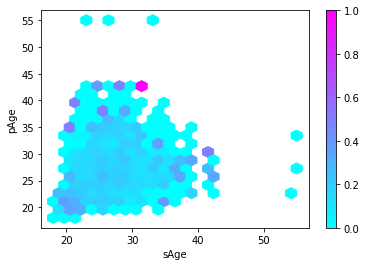

In [12]:
with_pAge(df).rename({'age':'sAge'}, axis='columns').plot.hexbin(
    x='sAge', y='pAge', C='match',
    cmap=plt.cm.cool, 
    reduce_C_function=np.mean, 
    gridsize=22,
    sharex=False, sharey=False)
plt.show()

In [13]:
X, Y = splitBy(preprocess(df), 'dec')
X = X.drop(columns=['gender'])

Accuracy: 68.26%
True negatives: 47.37%	False negatives: 11.81%
False positives: 19.93%	True positives: 20.88%



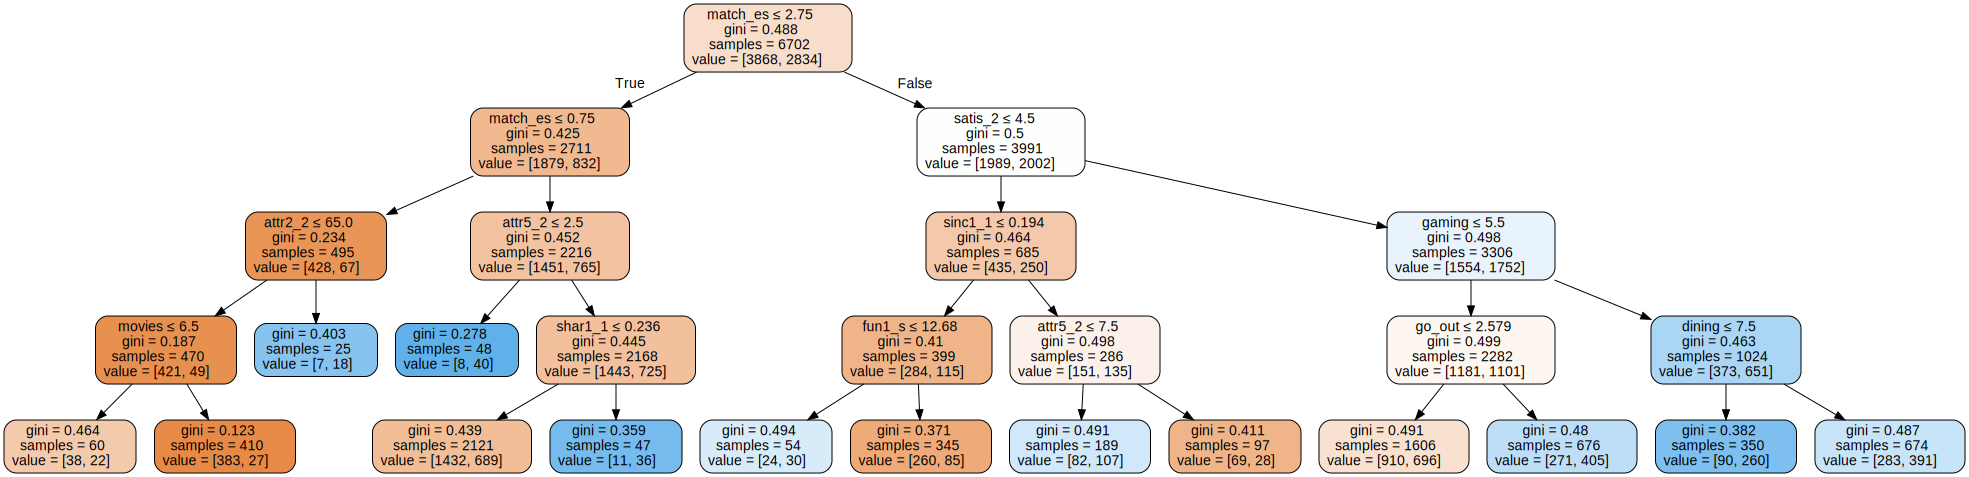

In [14]:
uni_model = model(X, Y, test_size=0.2)
vizualize(model(X, Y, test_size=0.2, max_depth=4, print_stats=False), X.columns)

Accuracy: 68.32%
True negatives: 47.32%	False negatives: 11.87%
False positives: 19.81%	True positives: 21.00%



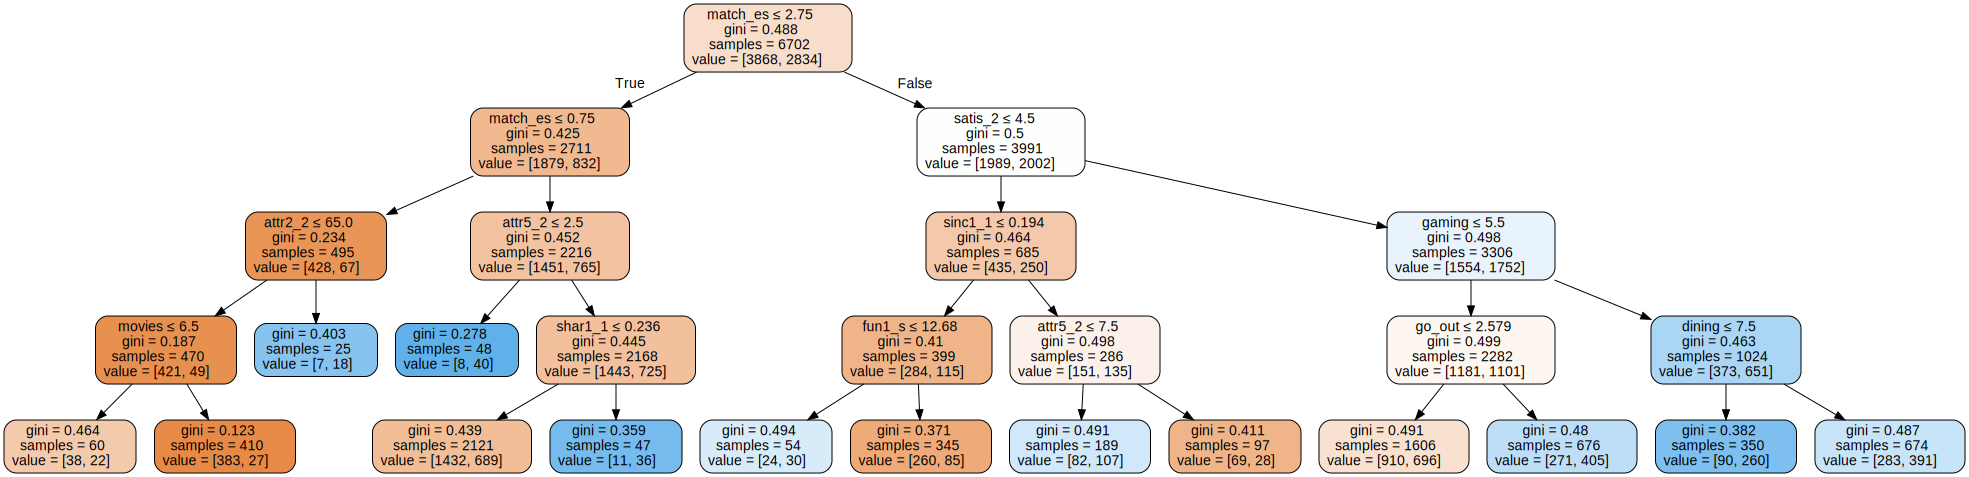

In [15]:
X_nobias = impute(X.drop(["race","imprace","imprelig","income"], axis=1))
nobias_model = model(X_nobias,Y, test_size=0.2)
vizualize(model(X_nobias,Y, max_depth=4, test_size=0.2, print_stats=False), X_nobias.columns)

In [16]:
def printDiscriminationScore(attr, d_uni, d_nobias):
    print("""Discrimination score(slift) towards {0}:
 Unisex model: {1}
 No bias model: {2}""".format(attr, d_uni, d_nobias))

In [17]:
def discriminationScore(df):
    means = df[['dec','nobias_dec','uni_dec']].mean()
    d_uni = abs(means['dec']-means['uni_dec'])
    d_nobias = abs(means['dec']-means['nobias_dec'])    
    return d_uni, d_nobias

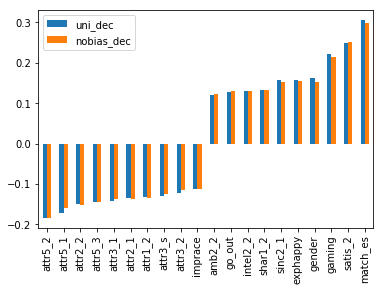

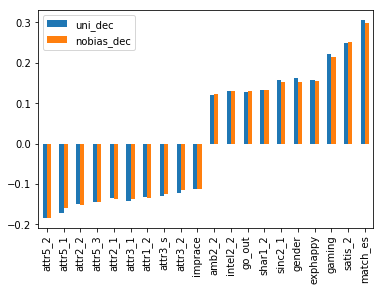

Discrimination score(slift) towards gender:
 Unisex model: 0.06938483547925606
 No bias model: 0.06819265617548875


shar1_1     0.088446
sinc2_1     0.101208
shar2_1     0.102880
sinc4_1     0.105119
shar4_1     0.114530
intel4_1    0.126004
sinc1_1     0.126129
gender      0.131579
intel2_1    0.131880
sinc5_1     0.133858
intel1_1    0.146563
sinc3_1     0.175633
fun1_1      0.185643
fun4_1      0.193753
attr3_1     0.193955
fun2_1      0.194866
fun5_1      0.199152
amb3_1      0.199279
fun3_1      0.212357
amb5_1      0.213737
attr5_1     0.217097
intel3_1    0.218776
amb4_1      0.219359
amb1_1      0.222051
amb2_1      0.226933
attr1_1     0.231169
intel5_1    0.236156
attr4_1     0.241235
attr2_1     0.242234
dec         0.710526
met         1.127534
race        1.526316
length      1.662708
match_es    2.000000
gaming      2.052632
numdat_2    2.160146
go_out      2.447368
sports      2.578947
tvsports    2.842105
goal        2.894737
exercise    3.447368
imprelig    3.500000
hiking      4.157895
imprace     4.289474
yoga        4.289474
concerts    5.210526
exphappy    5.263158
reading     5

In [31]:
df_dec = impute(preprocess(df.copy()))

df_dec['uni_dec'] = uni_model.predict(X.as_matrix())
df_dec['nobias_dec'] = nobias_model.predict(X_nobias.as_matrix())

print()

### Pearson coefficent of correlation between attributes and decisions
corr = df_dec.corr().drop(['uni_dec', 'nobias_dec', 'dec'])

### Sorted by unisex model correlation
uni_corr = corr[['uni_dec', 'nobias_dec']].sort_values(by='uni_dec')
uni_corr.head(10).append(uni_corr.tail(10)).plot.bar()
plt.show()

### Sorted by no-bias model correlation
nobias_corr = corr[['uni_dec', 'nobias_dec']].sort_values(by='nobias_dec')
nobias_corr.head(10).append(nobias_corr.tail(10)).plot.bar()
plt.show()

printDiscriminationScore('gender', *discriminationScore(df_dec[df_dec.gender == 1]))

not_equal = df_dec[df_dec.nobias_dec != df_dec.uni_dec]

### Cases where model decisions differ
display(not_equal.mean().drop(['uni_dec', 'nobias_dec']).sort_values().head(60))

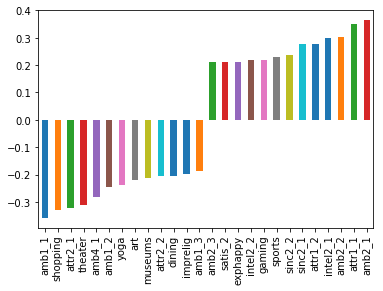

In [19]:
df = preprocess(df)

### Pearson coefficent of correlation between gender and attributes
corr = df.corr()['gender'].drop('gender').sort_values()
corr.head(13).append(corr.tail(13)).plot.bar()
plt.show()

#male_mean = df[df.gender == Gender.MALE].mean()
#fem_mean = df[df.gender == Gender.FEMALE].mean()

# Difference in attribute means in percent:
#diff = ((male_mean-fem_mean)/male_mean).drop('gender')
#display(diff.sort_values()*100)
#(male_mean-).drop(columns=['gender']).sort_values()

#df.corr()['gender'].drop('gender').sort_values()
#df.corr()['gender'].drop('gender').sort_values()[10:]
